<a href="https://colab.research.google.com/github/HiroshanI/Heart-Disease-Prediction-App/blob/model_comparison/Copy_of_heart_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📅 Import Tools and Data

In [ ]:
# Data exploration and manipulation
import pandas as pd
import numpy as np
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import plotly.graph_objects as go
# Data preparation
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from sklearn.svm import SVC
# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Save/Load model
import pickle
# Extras
import warnings

In [ ]:
# Ignore warnings
warnings.filterwarnings("ignore")
# Constants
MY_PALETTE= ["#525FE1","#F55353", "#FEB139", "#8F43EE", "#00DFA2"]
# Plot style
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams["axes.linewidth"] = 0
plt.rcParams["patch.linewidth"] = 0
plt.rcParams["figure.edgecolor"] = 'white'
plt.rcParams["figure.titleweight"] = 'bold'
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titleweight"] = 'normal'
plt.rcParams["axes.titlesize"] = 12
sns.set_palette(MY_PALETTE)

Read Dataset

In [ ]:
# Read dataset
data = pd.read_csv('input/heart_disease_uci.csv')
display(data.head().style.hide(axis='index'))
print(f"Dataset shape : {data.shape[0]} rows x {data.shape[1]} columns")

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
1,63,Male,Cleveland,typical angina,145.000000,233.000000,True,lv hypertrophy,150.000000,False,2.300000,downsloping,0.000000,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160.000000,286.000000,False,lv hypertrophy,108.000000,True,1.500000,flat,3.000000,normal,2
3,67,Male,Cleveland,asymptomatic,120.000000,229.000000,False,lv hypertrophy,129.000000,True,2.600000,flat,2.000000,reversable defect,1
4,37,Male,Cleveland,non-anginal,130.000000,250.000000,False,normal,187.000000,False,3.500000,downsloping,0.000000,normal,0
5,41,Female,Cleveland,atypical angina,130.000000,204.000000,False,lv hypertrophy,172.000000,False,1.400000,upsloping,0.000000,normal,0


Dataset shape : 920 rows x 16 columns


Basic Clean-up

In [ ]:
def basic_clean_data(data):
    data.rename(mapper={'num':'class'}, axis=1, inplace=True) # rename target column to "class"
    data.dropna(subset=['class'], axis=0, inplace=True) # drop rows if target is null
    data.drop_duplicates(keep='first', inplace=True) # drop duplicate rows
    #rename attributes that has space with _
    data["restecg"].replace({"lv hypertrophy": "lv_hypertrophy","st-t abnormality": "stt_abnormality" }, inplace=True)
    data['thal'].replace({'fixed defect':'fixed_defect' , 'reversable defect': 'reversable_defect' }, inplace =True)
    data['cp'].replace({'typical angina':'typical_angina', 'atypical angina': 'atypical_angina' }, inplace =True)
    return data
data = basic_clean_data(data)
display(data.head().style.hide(axis='index'))
print(f"Dataset shape : {data.shape[0]} rows x {data.shape[1]} columns")

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,class
1,63,Male,Cleveland,typical_angina,145.000000,233.000000,True,lv_hypertrophy,150.000000,False,2.300000,downsloping,0.000000,fixed_defect,0
2,67,Male,Cleveland,asymptomatic,160.000000,286.000000,False,lv_hypertrophy,108.000000,True,1.500000,flat,3.000000,normal,2
3,67,Male,Cleveland,asymptomatic,120.000000,229.000000,False,lv_hypertrophy,129.000000,True,2.600000,flat,2.000000,reversable_defect,1
4,37,Male,Cleveland,non-anginal,130.000000,250.000000,False,normal,187.000000,False,3.500000,downsloping,0.000000,normal,0
5,41,Female,Cleveland,atypical_angina,130.000000,204.000000,False,lv_hypertrophy,172.000000,False,1.400000,upsloping,0.000000,normal,0


Dataset shape : 920 rows x 16 columns


### 📊 Exploratory Data Analysis

Distribution of Data (Univariate Analysis)

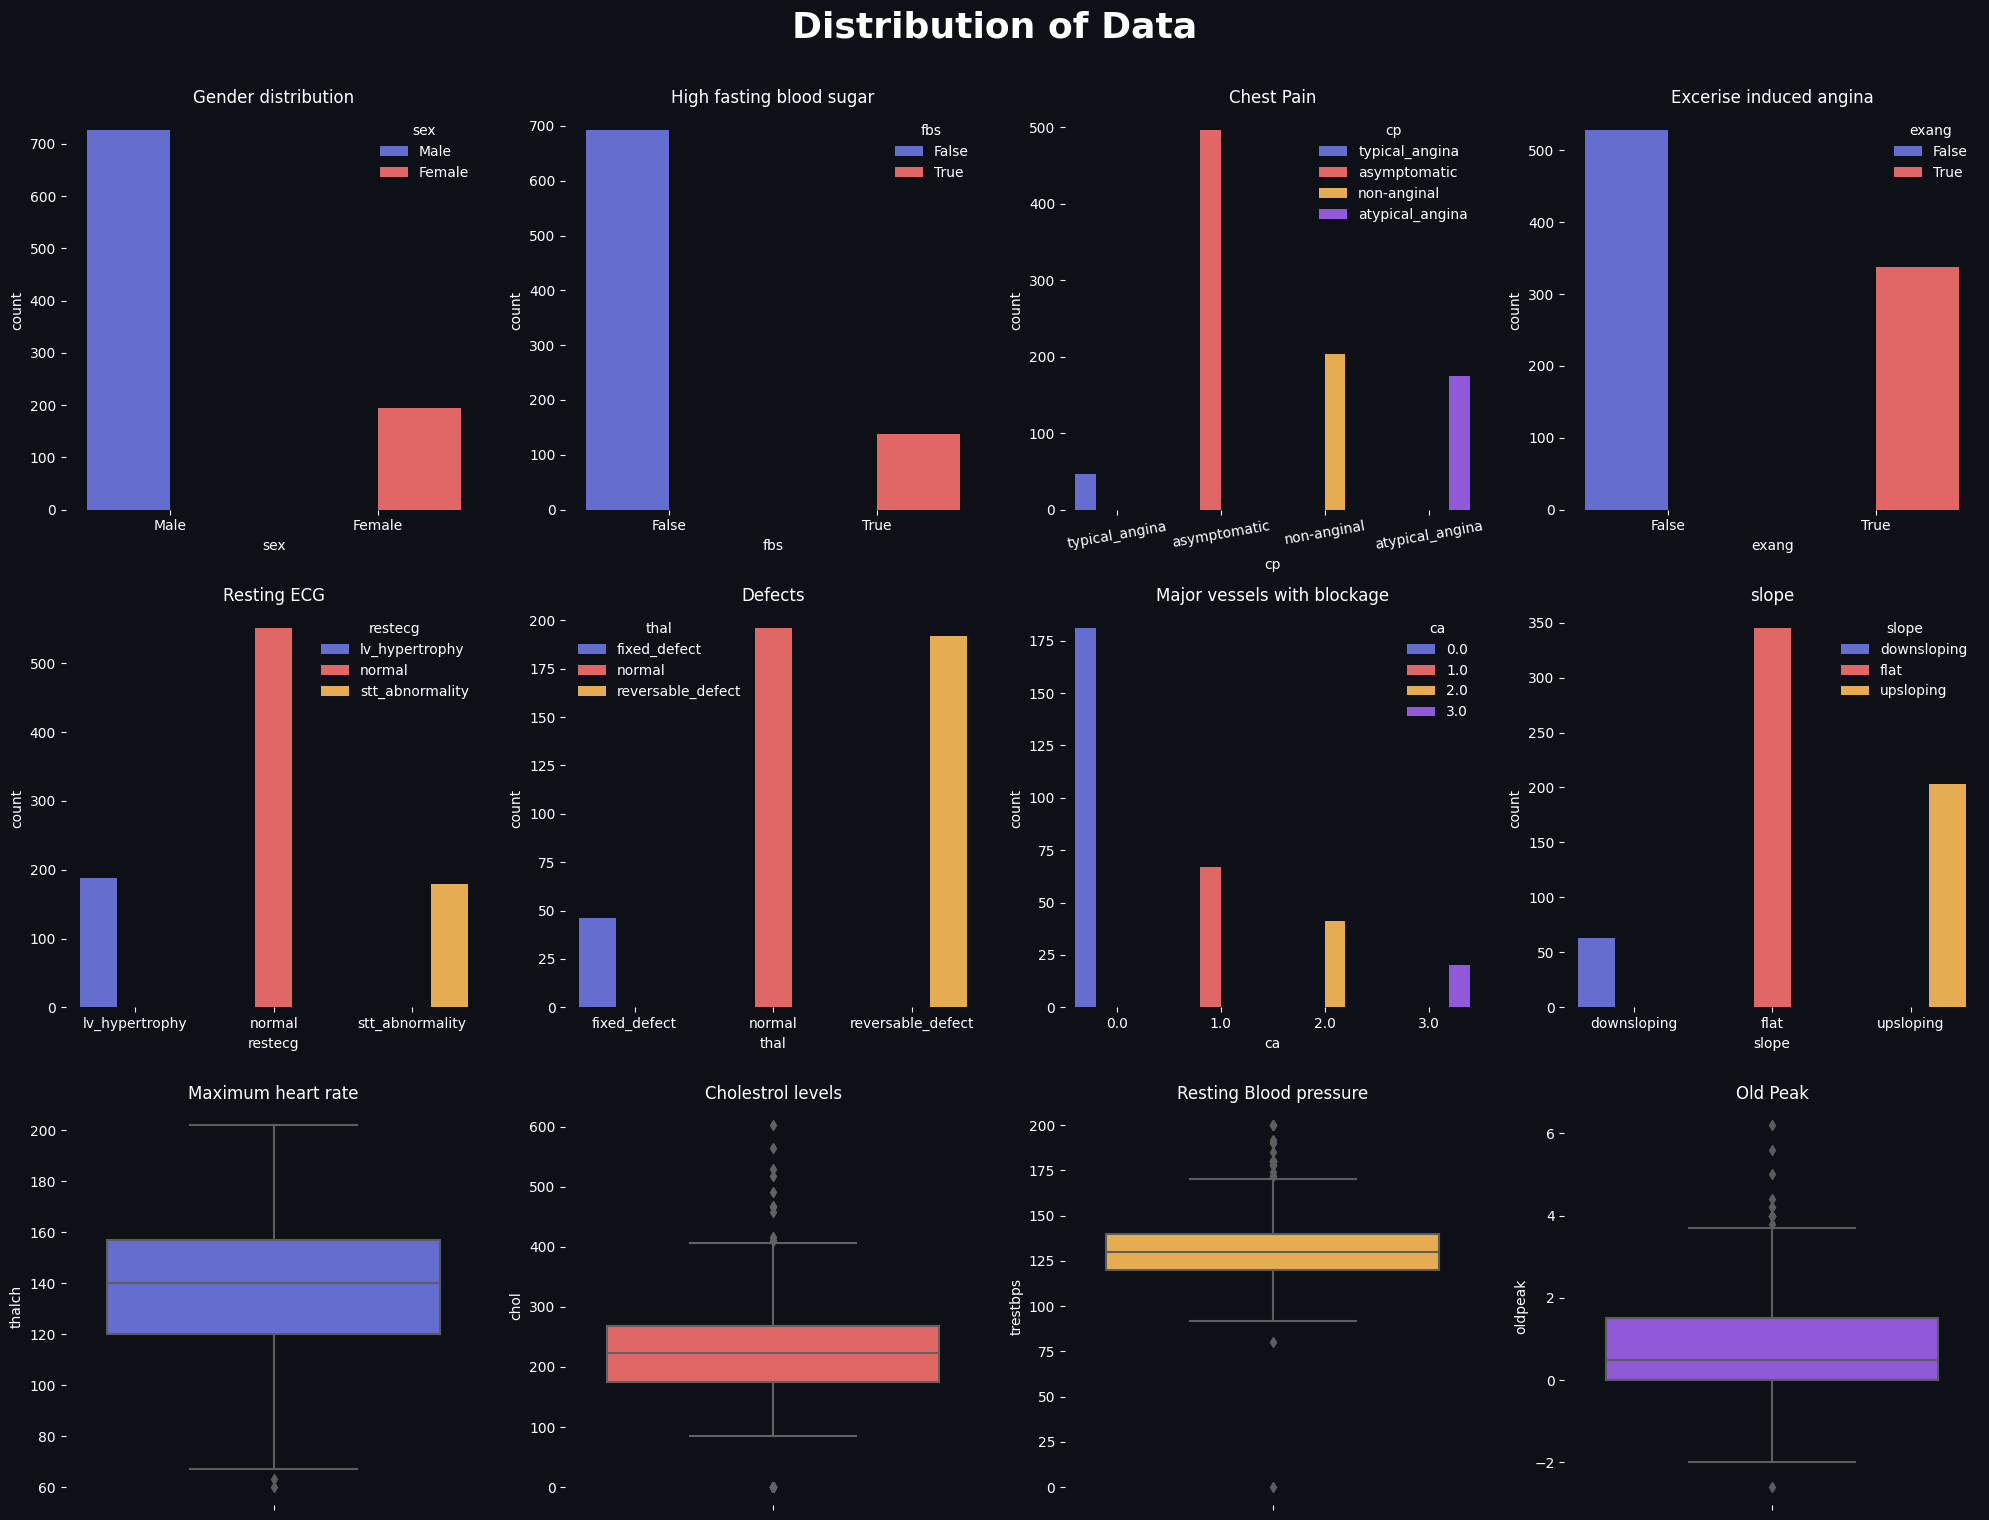

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,15))
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Distribution of Data", fontsize=26, y=1.01)
sns.set_palette(MY_PALETTE)
# Categorical Features
sns.countplot(data=data, x='sex', ax=axes[0,0], hue='sex')
axes[0,0].set_title("Gender distribution")
sns.countplot(data=data, x='fbs', ax=axes[0,1], hue='fbs')
axes[0,1].set_title("High fasting blood sugar")
sns.countplot(data=data, x='cp', ax=axes[0,2], hue='cp')
axes[0,2].set_title("Chest Pain")
sns.countplot(data=data, x='exang', ax=axes[0,3], hue='exang')
axes[0,3].set_title("Excerise induced angina")
axes[0,2].set_xticklabels(data['cp'].unique(), rotation=10)
sns.countplot(data=data, x='restecg', ax=axes[1,0], hue='restecg')
axes[1,0].set_title("Resting ECG")
sns.countplot(data=data, x='thal', ax=axes[1,1], hue='thal')
axes[1,1].set_title("Defects")
sns.countplot(data=data, x='ca', ax=axes[1,2], hue='ca', palette=MY_PALETTE)
axes[1,2].set_title("Major vessels with blockage")
sns.countplot(data=data, x='slope', ax=axes[1,3], hue='slope')
axes[1,3].set_title("slope")
# Numerical Features
sns.boxplot(data=data, y='thalch', ax=axes[2,0], color=MY_PALETTE[0])
axes[2,0].set_title("Maximum heart rate")
sns.boxplot(data=data, y='chol', ax=axes[2,1], color=MY_PALETTE[1])
axes[2,1].set_title("Cholestrol levels")
sns.boxplot(data=data, y='trestbps', ax=axes[2,2], color=MY_PALETTE[2])
axes[2,2].set_title("Resting Blood pressure")
sns.boxplot(data=data, y='oldpeak', ax=axes[2,3], color=MY_PALETTE[3])
axes[2,3].set_title("Old Peak")
plt.tight_layout()
plt.show()

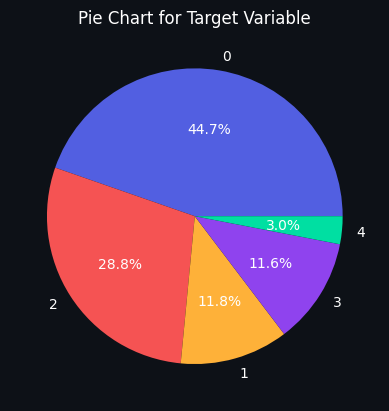

In [ ]:
# Analyzing the Target Feature and renaming it to suitable name
unique_values = data['class'].unique()

# Get the count of each unique value
counts = data['class'].value_counts()

# Calculate the percentage of each value
percentages = counts / counts.sum() * 100

# Create a pie chart
plt.pie(percentages, labels=unique_values, autopct='%1.1f%%')
plt.title('Pie Chart for Target Variable')
plt.show()

Bivariate Analysis

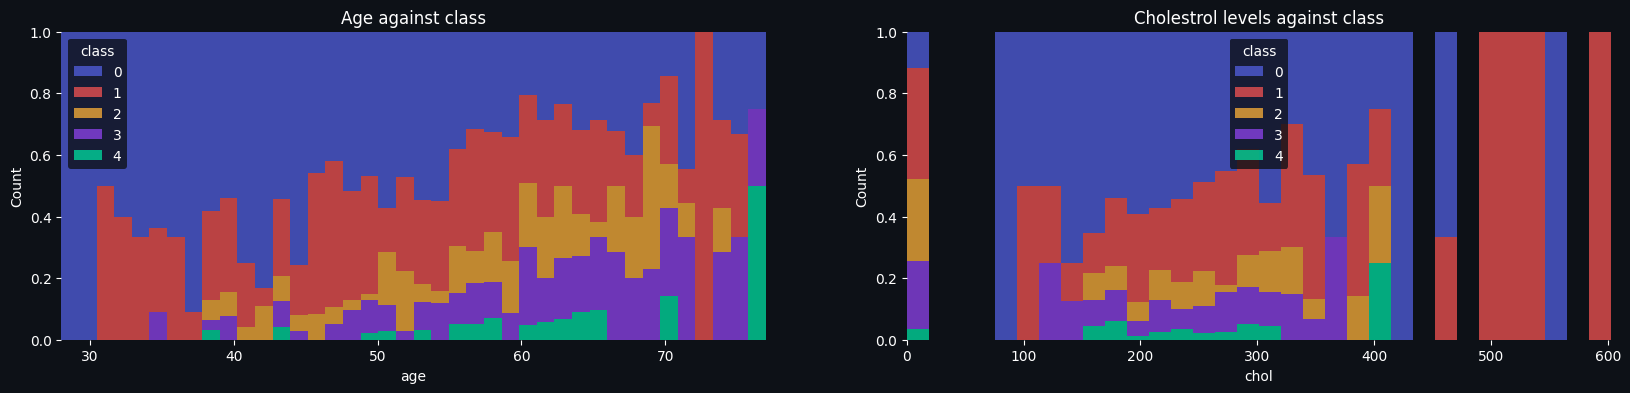

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))
#Age vs class
sns.histplot(data=data, x='age', hue='class',multiple="fill", bins=40, palette=MY_PALETTE, ax=axes[0])
axes[0].set_title("Age against class")
#Cholestrol levels vs class
sns.histplot(data=data, x='chol', hue='class',multiple="fill", palette=MY_PALETTE, ax=axes[1])
axes[1].set_title("Cholestrol levels against class")
plt.show()

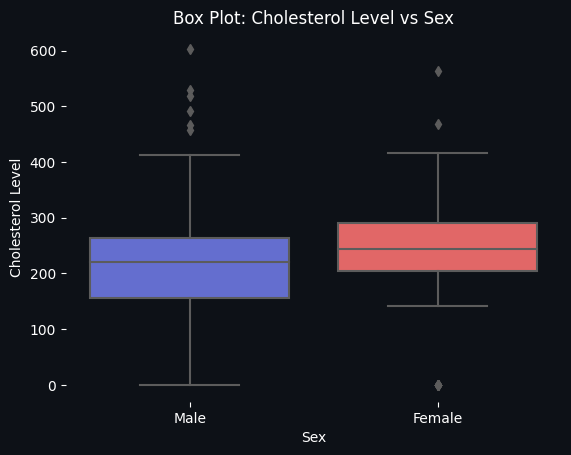

In [ ]:
#Box Plot for Cholestrol level vs Sex
sns.boxplot(x='sex', y='chol', data=data)
plt.title('Box Plot: Cholesterol Level vs Sex')
plt.xlabel('Sex')
plt.ylabel('Cholesterol Level')
plt.show()

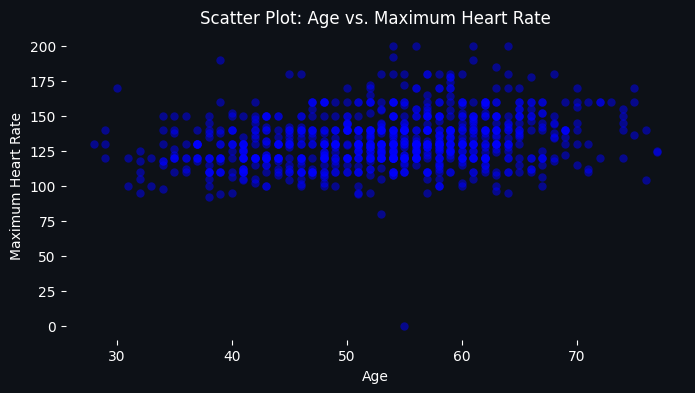

In [ ]:
#Scatter Plot for Age vs. Maximum Heart Rate
plt.figure(figsize=(8, 4))
plt.scatter(data['age'], data['trestbps'], color='blue', alpha=0.5)
plt.title('Scatter Plot: Age vs. Maximum Heart Rate')
plt.xlabel('Age')
plt.ylabel('Maximum Heart Rate')
plt.show()

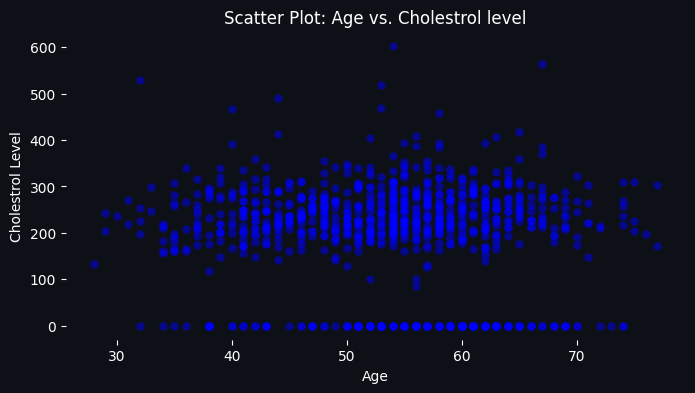

In [ ]:
#Scatter Plot for Age vs. Cholestrol Level

plt.figure(figsize=(8, 4))
plt.scatter(data['age'], data['chol'], color='blue', alpha=0.5)
plt.title('Scatter Plot: Age vs. Cholestrol level')
plt.xlabel('Age')
plt.ylabel('Cholestrol Level')
plt.show()

### 🔍 Missing values

How much is missing?

In [ ]:
# Checking for null values

data.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
class         0
dtype: int64

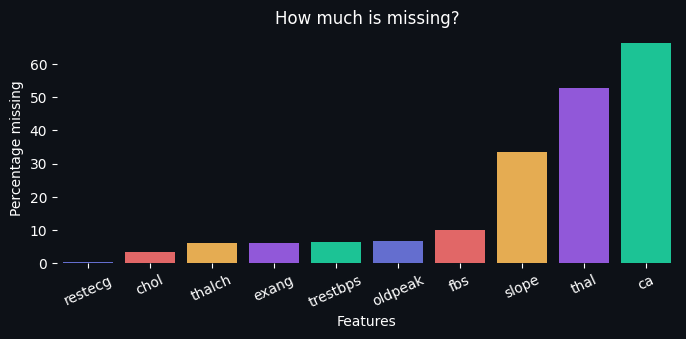

In [ ]:
# Missing column names
missing_val_cols = data.columns[data.isnull().any()]
# No. of missing values for each column
missing_vals = data[missing_val_cols].isnull().sum().sort_values()

plt.figure(figsize=(8,3))
sns.barplot(x=missing_vals.index, y=round(missing_vals/data.shape[0] * 100, 1), palette=MY_PALETTE)
plt.xticks(rotation=25)
plt.title("How much is missing?")
plt.xlabel("Features")
plt.ylabel("Percentage missing")
plt.show()

- `age` column does not have missing values
- More than half of `ca`, `slope`, `thal` values are missing
- Other features are missing less than 10% values

In [ ]:
#Records with null values
records_with_null = data[data.isnull().any(axis=1)]
records_with_null

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,class
87,88,53,Female,Cleveland,non-anginal,128.0,216.0,False,lv_hypertrophy,115.0,False,0.0,upsloping,0.0,NaN,0
166,167,52,Male,Cleveland,non-anginal,138.0,223.0,False,normal,169.0,False,0.0,upsloping,NaN,normal,0
192,193,43,Male,Cleveland,asymptomatic,132.0,247.0,True,lv_hypertrophy,143.0,True,0.1,flat,NaN,reversable_defect,1
266,267,52,Male,Cleveland,asymptomatic,128.0,204.0,True,normal,156.0,True,1.0,flat,0.0,NaN,2
287,288,58,Male,Cleveland,atypical_angina,125.0,220.0,False,normal,144.0,False,0.4,flat,NaN,reversable_defect,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,stt_abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical_angina,NaN,139.0,False,stt_abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,stt_abnormality,100.0,False,0.0,NaN,NaN,fixed_defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv_hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


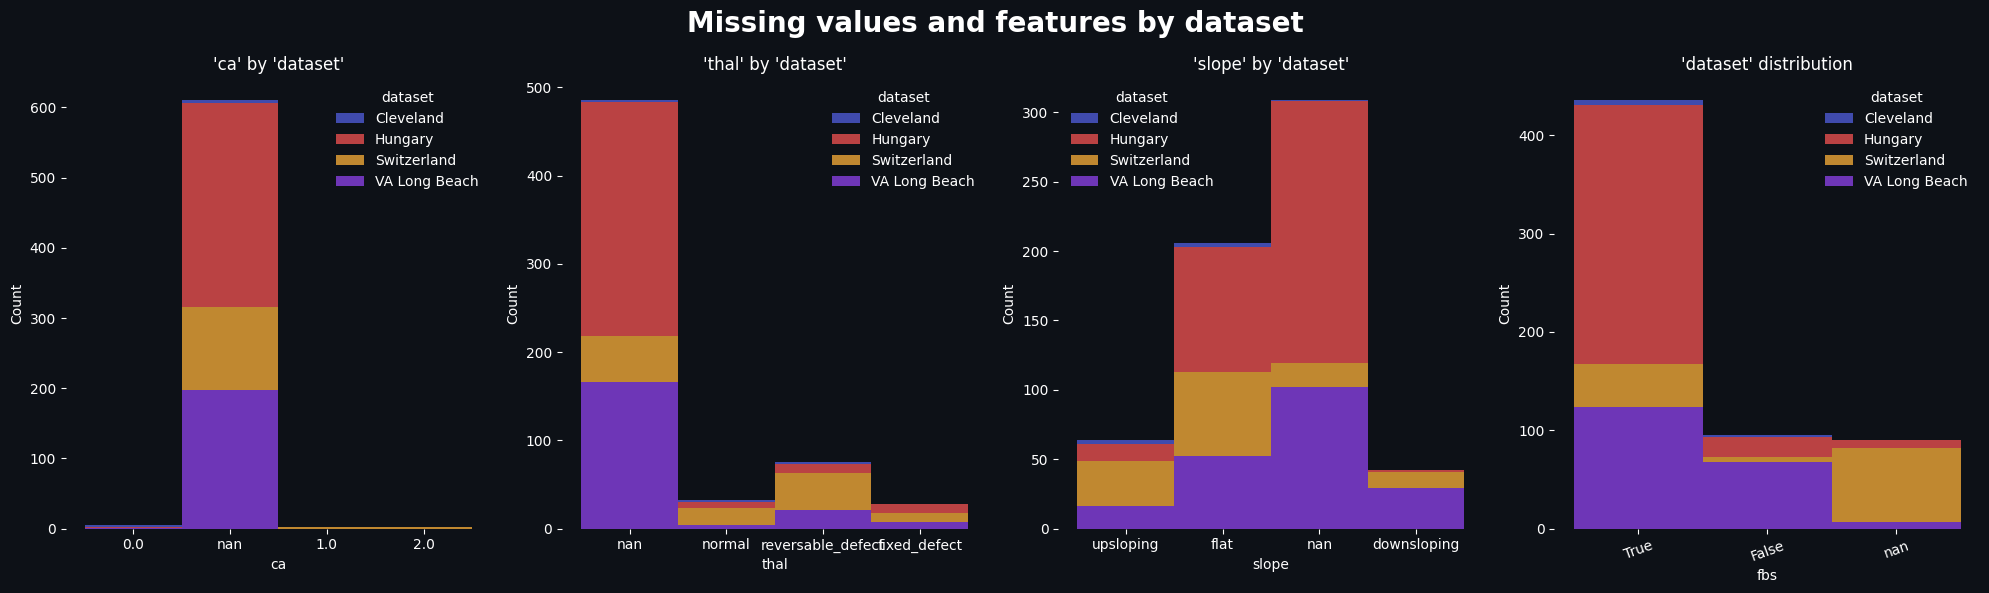

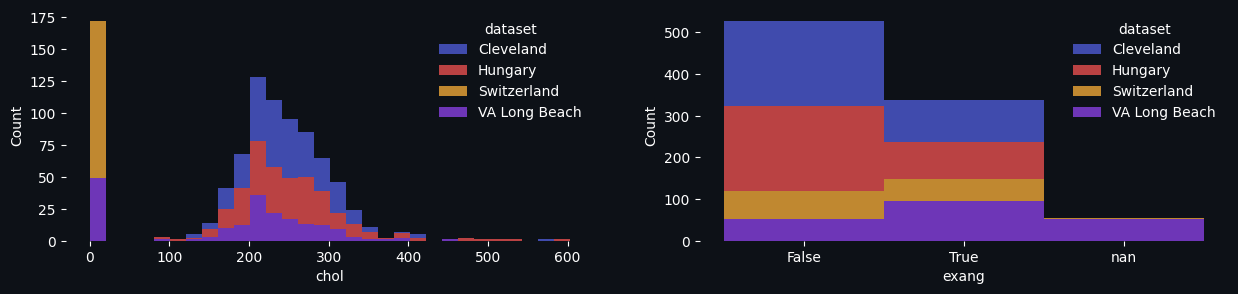

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))
fig.subplots_adjust(hspace=0.3)
fig.suptitle("Missing values and features by dataset")
sns.set_palette(MY_PALETTE)
sns.histplot(data=records_with_null, x=records_with_null['ca'].sort_values().astype('str'), hue='dataset', multiple='stack', ax=axes[0])
sns.histplot(data=records_with_null, x=records_with_null['thal'].sort_values().astype('str'), hue='dataset', multiple='stack', ax=axes[1])
sns.histplot(data=records_with_null, x=records_with_null['slope'].sort_values().astype('str'), hue='dataset', multiple='stack', ax=axes[2])
sns.histplot(data=records_with_null, x=records_with_null['fbs'].sort_values().astype('str'), hue='dataset', multiple='stack', ax=axes[3])
axes[0].set_title("'ca' by 'dataset'")
axes[1].set_title("'thal' by 'dataset'")
axes[2].set_title("'slope' by 'dataset'")
axes[3].set_title("'dataset' distribution")
axes[3].set_xticklabels(data['fbs'].unique(), rotation=20)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15,3))
sns.histplot(data=data, x='chol', bins=30, hue='dataset', multiple='stack', ax=axes[0])
sns.histplot(data=data, x=data['exang'].astype(str), hue='dataset', multiple='stack', ax=axes[1])
plt.show()

- `ca`,`thal`,`slope` and `fbs` doesn't have missing values from the `Cleveland` dataset

In [ ]:
#Dataset(location) Contributions for null records
df=records_with_null['dataset'].value_counts().reset_index().rename(columns={'index':'dataset','dataset':'count'})
fig = go.Figure([go.Pie(labels=df['dataset'],values=df['count'], hole = 0.5)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=15,insidetextorientation='radial')
fig.update_layout(title="Dataset Contributions for null records",title_x=0.5)
fig.show()

*   `Cleveland` dataset has the least impact on missing records
*   Therefore only data from `Cleveland` dataset will be selected

In [ ]:
X = data[data['dataset'] == "Cleveland"]
X.drop(['dataset'], axis=1, inplace=True)
display(X.head().style.hide(axis='index'))
print(f"Dataset shape : {X.shape[0]} rows x {X.shape[1]} columns")

id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,class
1,63,Male,typical_angina,145.000000,233.000000,True,lv_hypertrophy,150.000000,False,2.300000,downsloping,0.000000,fixed_defect,0
2,67,Male,asymptomatic,160.000000,286.000000,False,lv_hypertrophy,108.000000,True,1.500000,flat,3.000000,normal,2
3,67,Male,asymptomatic,120.000000,229.000000,False,lv_hypertrophy,129.000000,True,2.600000,flat,2.000000,reversable_defect,1
4,37,Male,non-anginal,130.000000,250.000000,False,normal,187.000000,False,3.500000,downsloping,0.000000,normal,0
5,41,Female,atypical_angina,130.000000,204.000000,False,lv_hypertrophy,172.000000,False,1.400000,upsloping,0.000000,normal,0


Dataset shape : 304 rows x 15 columns


### 📊 Exploratory Data Analysis

In [ ]:
temp = X.copy()
temp['Heart Disease'] = [y != 0 for y in temp['class']]

In [ ]:
# sns.histplot(data=temp, x='age', hue='sex', multiple='dodge', kde=True)
# sns.histplot(data=temp, x='chol', hue='sex', multiple='dodge', kde=True)

# sns.histplot(data=temp, x='age', hue='Heart Disease', multiple='stack', palette=MY_PALETTE, kde=True)
# sns.histplot(data=temp, x='chol', hue='Heart Disease', multiple='stack', palette=MY_PALETTE, kde=True)
# sns.histplot(data=temp, x='trestbps', hue='Heart Disease', multiple='stack', palette=MY_PALETTE, kde=True)
# sns.histplot(data=temp, x='chol', hue='Heart Disease', multiple='stack', palette=MY_PALETTE, kde=True)

# sns.lmplot(data=temp, x='age', y='chol_', hue='Heart Disease')
# from scipy.stats.mstats import winsorize
# temp['chol_'] = winsorize(temp['chol'], limits=[0, 0.01])
# sns.boxplot(data=temp, y="chol_", hue="Heart Disease")

df = temp.groupby('Heart Disease')[['sex','thal','exang','restecg','fbs','cp']].value_counts().reset_index()
df[0]

# plt.pie(temp['Heart Disease'].value_counts())

0      15
1      11
2      11
3      10
4       9
       ..
100     1
101     1
102     1
103     1
104     1
Name: 0, Length: 105, dtype: int64

### 🪓 Split Data

- No testing set so split the dataset into training and testing
- Doing this early before manipulation to prevent data leakage
- Splitting ratio ➡️ 80 : 20


In [ ]:
# Constants
RANDOM_STATE=42
NUM_COLS = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
CAT_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [ ]:
# Separate data into target and features
y = X['class']
X = X.drop('class', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=RANDOM_STATE)

print(tabulate(zip(['Training set', 'Testing set'],[X_train.shape, X_valid.shape]),
               headers=['Data', '(Rows, Columns)']))

Data          (Rows, Columns)
------------  -----------------
Training set  (243, 14)
Testing set   (61, 14)


In [ ]:
#Training data
X_train

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
269,270,42,Male,non-anginal,130.0,180.0,False,normal,150.0,False,0.0,upsloping,0.0,normal
211,212,38,Male,typical_angina,120.0,231.0,False,normal,182.0,True,3.8,flat,0.0,reversable_defect
197,198,45,Female,asymptomatic,138.0,236.0,False,lv_hypertrophy,152.0,True,0.2,flat,0.0,normal
75,76,65,Female,non-anginal,160.0,360.0,False,lv_hypertrophy,151.0,False,0.8,upsloping,0.0,normal
177,178,56,Male,asymptomatic,132.0,184.0,False,lv_hypertrophy,105.0,True,2.1,flat,1.0,fixed_defect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,189,54,Male,atypical_angina,192.0,283.0,False,lv_hypertrophy,195.0,False,0.0,upsloping,1.0,reversable_defect
71,72,67,Male,asymptomatic,125.0,254.0,True,normal,163.0,False,0.2,flat,2.0,reversable_defect
106,107,59,Male,asymptomatic,140.0,177.0,False,normal,162.0,True,0.0,upsloping,1.0,reversable_defect
270,271,61,Male,asymptomatic,140.0,207.0,False,lv_hypertrophy,138.0,True,1.9,upsloping,1.0,reversable_defect


In [ ]:
#Testing data
X_valid

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
180,181,48,Male,asymptomatic,124.0,274.0,False,lv_hypertrophy,166.0,False,0.5,flat,0.0,reversable_defect
154,155,64,Male,asymptomatic,120.0,246.0,False,lv_hypertrophy,96.0,True,2.2,downsloping,1.0,normal
111,112,56,Male,asymptomatic,125.0,249.0,True,lv_hypertrophy,144.0,True,1.2,flat,1.0,normal
247,248,47,Male,asymptomatic,110.0,275.0,False,lv_hypertrophy,118.0,True,1.0,flat,1.0,normal
60,61,51,Female,asymptomatic,130.0,305.0,False,normal,142.0,True,1.2,flat,0.0,reversable_defect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,219,64,Female,asymptomatic,130.0,303.0,False,normal,122.0,False,2.0,flat,2.0,normal
104,105,49,Male,non-anginal,120.0,188.0,False,normal,139.0,False,2.0,flat,3.0,reversable_defect
301,302,57,Female,atypical_angina,130.0,236.0,False,lv_hypertrophy,174.0,False,0.0,flat,1.0,normal
194,195,68,Female,non-anginal,120.0,211.0,False,lv_hypertrophy,115.0,False,1.5,flat,0.0,normal


### 🥣 Prepare Data

Fill missing numerical values with median

In [ ]:
imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(imputer.fit_transform(X_train[NUM_COLS]))
X_valid_num = pd.DataFrame(imputer.transform(X_valid[NUM_COLS]))
X_train_num.head(2)

,0,1,2,3,4
0,42.0,130.0,180.0,150.0,0.0
1,38.0,120.0,231.0,182.0,3.8


Standardize numerical values

In [ ]:
num_scaler = RobustScaler()
num_scaler.fit(X_train_num)
X_train_num = pd.DataFrame(num_scaler.transform(X_train_num))
X_valid_num = pd.DataFrame(num_scaler.transform(X_valid_num))
X_valid_num.columns, X_train_num.columns = NUM_COLS, NUM_COLS # restore column names
X_train_num.head(2)

,age,trestbps,chol,thalch,oldpeak
0,-0.928571,0.00000,-0.984127,-0.057971,-0.500
1,-1.214286,-0.47619,-0.174603,0.869565,1.875


Fill missing categorical values with mode

In [ ]:
imputer = SimpleImputer(strategy="most_frequent")
X_train_cat = pd.DataFrame(imputer.fit_transform(X_train[CAT_COLS]))
X_valid_cat = pd.DataFrame(imputer.transform(X_valid[CAT_COLS]))
X_train_cat.columns, X_valid_cat.columns = CAT_COLS, CAT_COLS # restore column names
X_train_cat.head(2)

,sex,cp,fbs,restecg,exang,slope,ca,thal
0,Male,non-anginal,False,normal,False,upsloping,0.0,normal
1,Male,typical_angina,False,normal,True,flat,0.0,reversable_defect


Encode categorical features

In [ ]:
#Categorical data in training dataset after preprocessing
display(X_train_cat.head().style.hide(axis='index'))
print("Number of records with null values: ",X_train_cat.isnull().any(axis=1).sum())

sex,cp,fbs,restecg,exang,slope,ca,thal
Male,non-anginal,False,normal,False,upsloping,0.000000,normal
Male,typical_angina,False,normal,True,flat,0.000000,reversable_defect
Female,asymptomatic,False,lv_hypertrophy,True,flat,0.000000,normal
Female,non-anginal,False,lv_hypertrophy,False,upsloping,0.000000,normal
Male,asymptomatic,False,lv_hypertrophy,True,flat,1.000000,fixed_defect


Number of records with null values:  0


In [ ]:
#Categorical data in testing dataset after preprocessing
display(X_valid_cat.head().style.hide(axis='index'))
print("Number of records with null values: ",X_valid_cat.isnull().any(axis=1).sum())

sex,cp,fbs,restecg,exang,slope,ca,thal
Male,asymptomatic,False,lv_hypertrophy,False,flat,0.000000,reversable_defect
Male,asymptomatic,False,lv_hypertrophy,True,downsloping,1.000000,normal
Male,asymptomatic,True,lv_hypertrophy,True,flat,1.000000,normal
Male,asymptomatic,False,lv_hypertrophy,True,flat,1.000000,normal
Female,asymptomatic,False,normal,True,flat,0.000000,reversable_defect


Number of records with null values:  0


In [ ]:
#One hot encoding for nominal features
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_ohenc = pd.DataFrame(oh_encoder.fit_transform(X_train_cat))
X_valid_cat_ohenc = pd.DataFrame(oh_encoder.transform(X_valid_cat))
X_train_cat_ohenc.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#Ordinal encoding for ordinal features
or_encoder = OrdinalEncoder()
X_train_cat_orenc = pd.DataFrame(or_encoder.fit_transform(X_train_cat))
X_valid_cat_orenc = pd.DataFrame(or_encoder.transform(X_valid_cat))
X_train_cat_orenc.head()

,0,1,2,3,4,5,6,7
0,1.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0
1,1.0,3.0,0.0,1.0,1.0,1.0,0.0,2.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


Combine numerical and categorical data

In [ ]:
# Concatenate column-wise
X_train_final = pd.concat([X_train_num, X_train_cat_ohenc], axis=1)
X_valid_final = pd.concat([X_valid_num, X_valid_cat_ohenc], axis=1)
# Change column name type to string
X_train_final.columns, X_valid_final.columns = X_train_final.columns.astype(str),  X_valid_final.columns.astype(str)
print(f"Training set shape : {X_train_final.shape}")
print(f"Testing set shape : {X_valid_final.shape}")

Training set shape : (243, 28)
Testing set shape : (61, 28)


Original VS. Preprocessed Data

In [ ]:
print(f"Original ➡️ {X_train.shape}")
display(X_train.head(2))
print(f"Preprocessed ➡️ {X_train_final.shape}")
display(X_train_final.head(2))

Original ➡️ (243, 14)


,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
269,270,42,Male,non-anginal,130.0,180.0,False,normal,150.0,False,0.0,upsloping,0.0,normal
211,212,38,Male,typical_angina,120.0,231.0,False,normal,182.0,True,3.8,flat,0.0,reversable_defect


Preprocessed ➡️ (243, 28)


,age,trestbps,chol,thalch,oldpeak,0,1,2,3,4,...,13,14,15,16,17,18,19,20,21,22
0,-0.928571,0.00000,-0.984127,-0.057971,-0.500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.214286,-0.47619,-0.174603,0.869565,1.875,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Change target to Binary

In [ ]:
y_train_binary = pd.Series([int(y != 0) for y in y_train], name="Heart Disease")
y_valid_binary = pd.Series([int(y != 0) for y in y_valid], name="Heart Disease")
y_train_binary


0      0
1      1
2      0
3      0
4      1
      ..
238    1
239    1
240    1
241    1
242    0
Name: Heart Disease, Length: 243, dtype: int64

### 👷‍♂️ Model Development

**Random Forest Classifier**

In [ ]:
#Training the Random Forest Classifier
rfc_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rfc_model.fit(X_train_final, y_train_binary);

In [ ]:
#Evaluating the Random Forest Classifier (RFC) model on both the training and validation datasets

#For the training data
rfc_train_preds = rfc_model.predict(X_train_final)

#For the testing data
rfc_test_preds = rfc_model.predict(X_valid_final)

#Print classification report for the model's predictions on the validation dataset
print(classification_report(y_valid_binary, rfc_test_preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.89      0.83      0.86        29

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



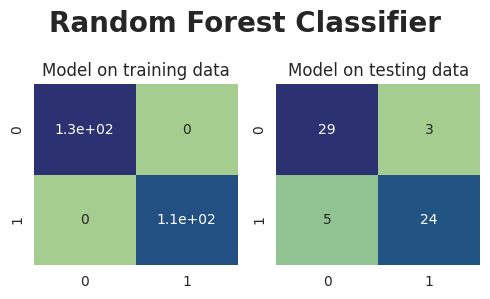

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
fig.suptitle("Random Forest Classifier")
#Confusion matrix for the training data
axes[0].set_title("Model on training data")
sns.heatmap(confusion_matrix(y_train_binary, rfc_train_preds),  annot=True, cmap='crest', cbar=False, ax=axes[0])
#Confusion matrix for the testing data
axes[1].set_title("Model on testing data")
sns.heatmap(confusion_matrix(y_valid_binary, rfc_test_preds),  annot=True, cmap='crest', cbar=False, ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
#Calculating the accuracy scores
acc_scores = []
ac = accuracy_score(y_valid_binary, rfc_test_preds)
acc_scores.append(ac)
print(ac)

0.8688524590163934


**Logistic Regression**

In [ ]:
#Training the Logistic Regression Model
log_model = LogisticRegression(random_state=RANDOM_STATE)
log_model.fit(X_train_final, y_train_binary);

In [ ]:
#Evaluating the Logistic Regression model on both the training and validation datasets

#For the training data
lr_train_preds = log_model.predict(X_train_final)

#For the testing data
lr_test_preds = log_model.predict(X_valid_final)

#Print classification report for the model's predictions on the validation dataset
print(classification_report(y_valid_binary, lr_test_preds))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.83      0.83      0.83        29

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



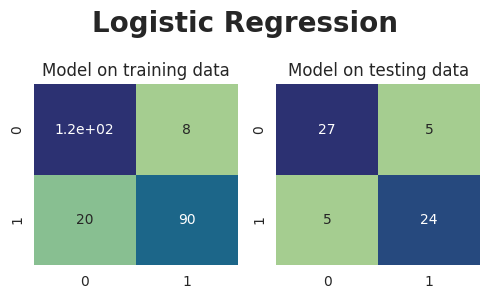

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
fig.suptitle("Logistic Regression")
#Confusion matrix for the training data
axes[0].set_title("Model on training data")
sns.heatmap(confusion_matrix(y_train_binary, lr_train_preds), annot=True, cmap='crest', cbar=False, ax=axes[0])
#Confusion matrix for the testing data
axes[1].set_title("Model on testing data")
sns.heatmap(confusion_matrix(y_valid_binary, lr_test_preds), annot=True, cmap='crest', cbar=False, ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
#Calculating the accuracy scores
ac = accuracy_score(y_valid_binary, lr_test_preds)
acc_scores.append(ac)
print(ac)

0.8360655737704918


**ANN model**

In [ ]:
#Training the ANN Model
ann_model = keras.Sequential([
    keras.layers.Dense(28, input_shape=(28,), activation='relu'),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = ann_model.fit(X_train_final, y_train_binary,
                        validation_data=(X_valid_final, y_valid_binary),
                        epochs=200, verbose=False);

In [ ]:
#Evaluating the ANN model on both the training and validation datasets

#For the training data
ann_train_preds = ann_model.predict(X_train_final, verbose=False)

#For the testing data
ann_test_preds = ann_model.predict(X_valid_final, verbose=False)

#Convert continuous predictions to binary predictions
ann_test_preds_binary = (ann_test_preds >= 0.5).astype(int)
ann_train_preds_binary = (ann_train_preds >= 0.5).astype(int)

print(classification_report(y_valid_binary, [int(y>0.5) for y in ann_test_preds]))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.77      0.83      0.80        29

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



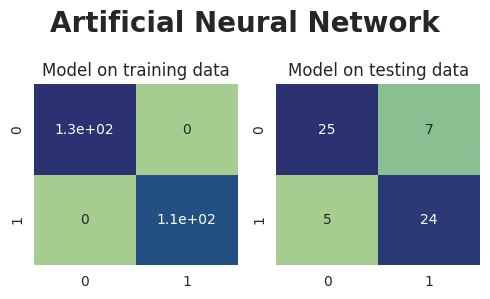

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
fig.suptitle("Artificial Neural Network")
#Confusion matrix for the training data
axes[0].set_title("Model on training data")
sns.heatmap(confusion_matrix(y_train_binary, ann_train_preds_binary), annot=True, cmap='crest', cbar=False, ax=axes[0])
#Confusion matrix for the testing data
axes[1].set_title("Model on testing data")
sns.heatmap(confusion_matrix(y_valid_binary, ann_test_preds_binary), annot=True, cmap='crest', cbar=False, ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
#Calculating the accuracy scores
ac = accuracy_score(y_valid_binary, [int(y>0.5) for y in ann_test_preds])
acc_scores.append(ac)
print(ac)

0.8032786885245902


**SVC model**

In [ ]:
#Training the SVC Model
svc_model = SVC(kernel='linear', C=0.01, probability=True)
svc_model.fit(X_train_final, y_train_binary);

In [ ]:
#Evaluating the SVC model on both the training and validation datasets

#For the training data
svc_train_preds = svc_model.predict(X_train_final)

#For the testing data
svc_test_preds = svc_model.predict(X_valid_final)
print(classification_report(y_valid_binary, svc_test_preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.86      0.86      0.86        29

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



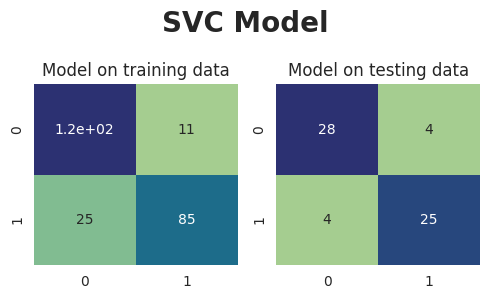

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
fig.suptitle("SVC Model")
#Confusion matrix for the training data
axes[0].set_title("Model on training data")
sns.heatmap(confusion_matrix(y_train_binary, svc_train_preds), annot=True, cmap='crest', cbar=False, ax=axes[0])
#Confusion matrix for the testing data
axes[1].set_title("Model on testing data")
sns.heatmap(confusion_matrix(y_valid_binary, svc_test_preds), annot=True, cmap='crest', cbar=False, ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
#Calculating the accuracy scores
ac = accuracy_score(y_valid_binary, svc_test_preds)
acc_scores.append(ac)
print(ac)

0.8688524590163934


Model Comparison

In [ ]:
model_list = ["Random Forest Classification","Logistic Regression","ANN","SVC"]

In [ ]:
acc_scores

[0.8688524590163934,
 0.8360655737704918,
 0.8032786885245902,
 0.8688524590163934]

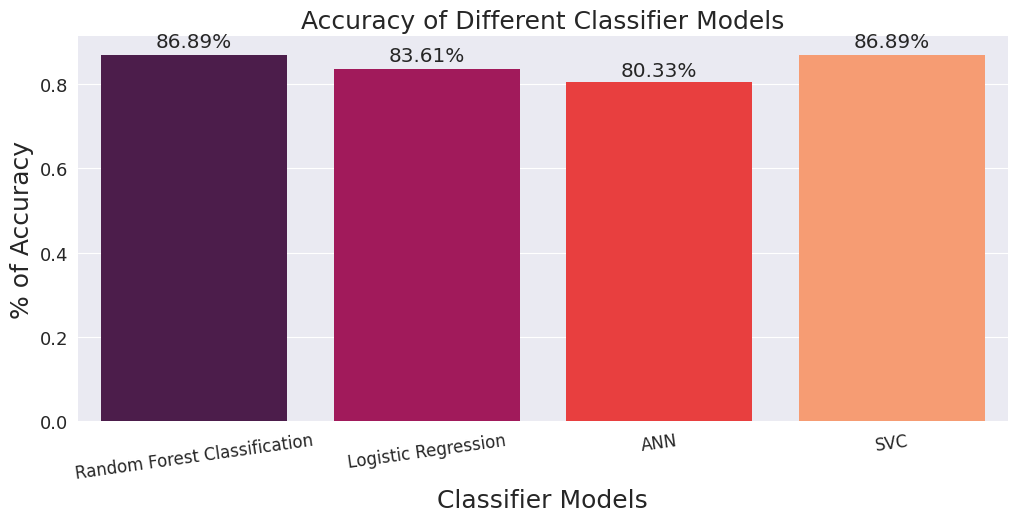

In [ ]:
plt.rcParams['figure.figsize']=12,5
sns.set_style("darkgrid")
ax = sns.barplot(x=model_list, y=acc_scores, palette = "rocket", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 18 )
plt.ylabel("% of Accuracy", fontsize = 18)
plt.title("Accuracy of Different Classifier Models", fontsize = 18)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

*   Random Forest Classifier and SVC models give the highest accuracy




### 💝 Save Model

In [ ]:
filename = "heart_model_data.pkl"
path = "output/"
model_data = {
    'rfc_model': rfc_model,
    'log_model': log_model,
    'ann_model': ann_model,
    'svc_model': svc_model,
    'or_encoder': or_encoder,
    'encoder': oh_encoder,
    'scaler': num_scaler
    }
pickle.dump(model_data, open(path + filename, 'wb'))

In [ ]:
display(X_valid.head(5))
y_valid_binary.head(5)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
180,181,48,Male,asymptomatic,124.0,274.0,False,lv hypertrophy,166.0,False,0.5,flat,0.0,reversable defect
154,155,64,Male,asymptomatic,120.0,246.0,False,lv hypertrophy,96.0,True,2.2,downsloping,1.0,normal
111,112,56,Male,asymptomatic,125.0,249.0,True,lv hypertrophy,144.0,True,1.2,flat,1.0,normal
247,248,47,Male,asymptomatic,110.0,275.0,False,lv hypertrophy,118.0,True,1.0,flat,1.0,normal
60,61,51,Female,asymptomatic,130.0,305.0,False,normal,142.0,True,1.2,flat,0.0,reversable defect


0    1
1    1
2    1
3    1
4    1
Name: Heart Disease, dtype: int64